In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import utils
import os

# Load and prepare data

In [3]:
(train_ds, valid_ds, test_ds), info_ds = tfds.load(
    'oxford_iiit_pet', split=['train', 'test[50:]', 'test[:50]'], 
    with_info=True, data_dir='data/'
)

In [4]:
@tf.function
def map_data(data):
    image, mask = data['image'], data['segmentation_mask']
    
    # Image norm
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (256, 256))
    image = image / 255.
    
    # Mask norm
    mask = tf.cast(mask, tf.float32)
    mask = tf.image.resize(mask, (256, 256))
    mask -= 1
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.one_hot(mask, 3)
    
    return image, mask

In [5]:
train_ds = train_ds.shuffle(len(train_ds)).map(map_data, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
vali_ds = valid_ds.map(map_data, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Model building
- Build mini version of unet

In [6]:
input_layer = tf.keras.layers.Input(shape=(256, 256, 3))

# First downsampling layer
conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

ups = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(4, 4), activation='relu', padding='same')(pool2)
up3 = tf.keras.layers.concatenate([conv1, ups], axis=3)

conv4 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(up3)
conv5 = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(conv4) # 3 represents the num of classes

model = tf.keras.Model(inputs=input_layer, outputs=conv5)
 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 73856       max_pooling2d[0][0]              
_______________________________________________________________________________________

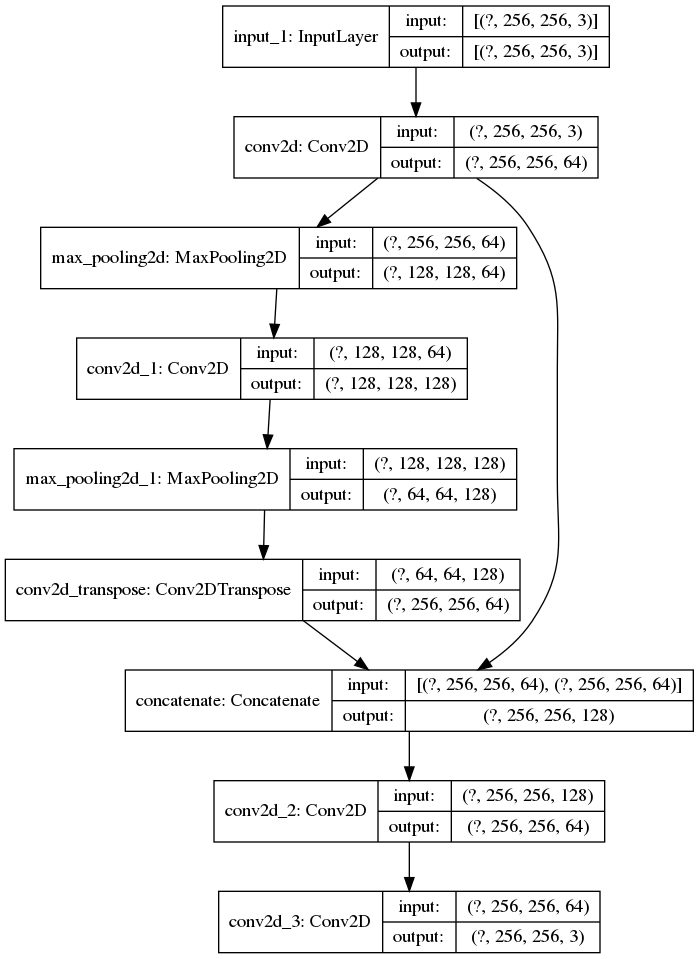

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Train and plot history

In [8]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    metrics=[sm.metrics.IOUScore(threshold=0.5), 'accuracy', sm.metrics.FScore(threshold=0.5)]
)

In [9]:
history = model.fit(train_ds, validation_data=vali_ds, epochs=10)

Epoch 1/10
  2/115 [..............................] - ETA: 21s - loss: 1.1093 - iou_score: 2.2211e-11 - accuracy: 0.2833 - f1-score: 2.2211e-11WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1286s vs `on_train_batch_end` time: 0.2325s). Check your callbacks.


115/115 [==============================] - 52s 451ms/step - loss: 0.9540 - iou_score: 0.1279 - accuracy: 0.5835 - f1-score: 0.1746 - val_loss: 0.9284 - val_iou_score: 0.1729 - val_accuracy: 0.5856 - val_f1-score: 0.2274
Epoch 2/10
115/115 [==============================] - 52s 454ms/step - loss: 0.8874 - iou_score: 0.1914 - accuracy: 0.5958 - f1-score: 0.2429 - val_loss: 0.8829 - val_iou_score: 0.1925 - val_accuracy: 0.5856 - val_f1-score: 0.2438
Epoch 3/10
115/115 [==============================] - 51s 445ms/step - loss: 0.8462 - iou_score: 0.1937 - accuracy: 0.5967 - f1-score: 0.2447 - val_loss: 0.8335 - val_iou_score: 0.1962 - val_accuracy: 0.5937 - val_f1-score: 0.2470
Epoch 4/10
115/115 [==============================] - 51s 447ms/step - loss: 0.8118 - iou_score: 0.2020 - accuracy: 0.6139 - f1-score: 0.2578 - val_loss: 0.8050 - val_iou_score: 0.2146 - val_accuracy: 0.6233 - val_f1-score: 0.2809
Epoch 5/10
115/115 [==============================] - 51s 447ms/step - loss: 0.7934 - i

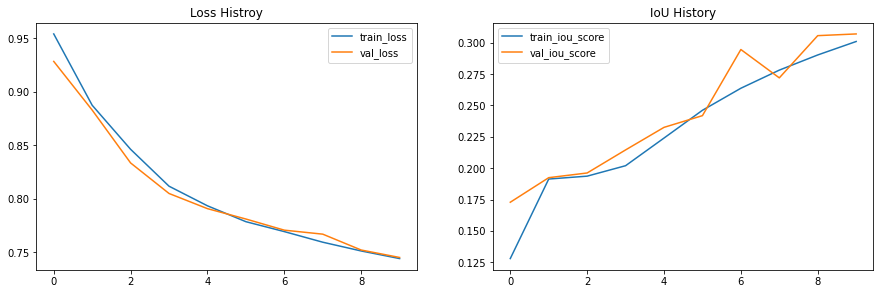

In [10]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.title('Loss Histroy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(222)
plt.title('IoU History')
plt.plot(history.history['iou_score'], label='train_iou_score')
plt.plot(history.history['val_iou_score'], label='val_iou_score')
plt.legend()

# Visual Evaluation

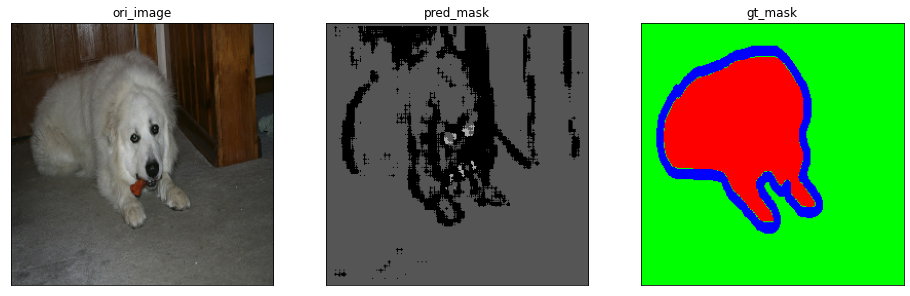

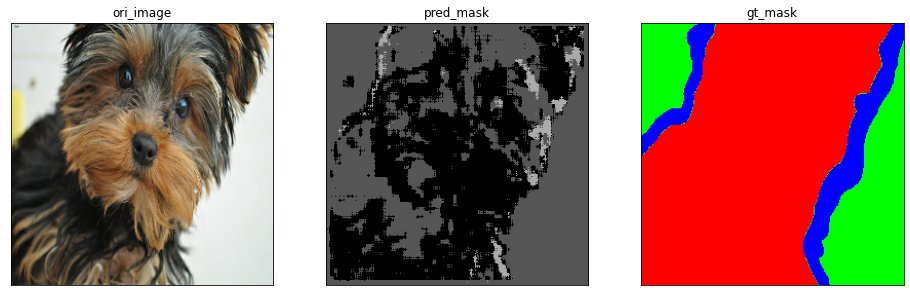

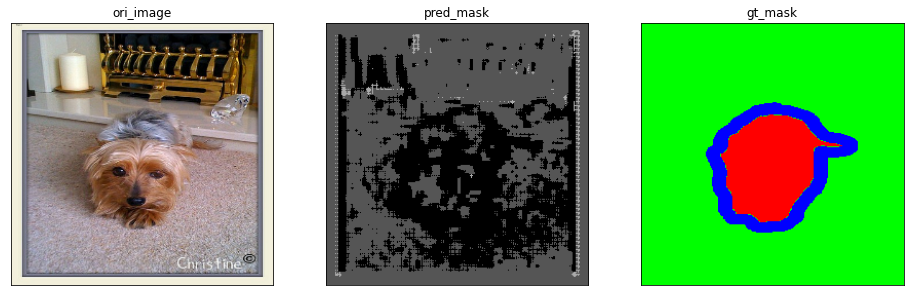

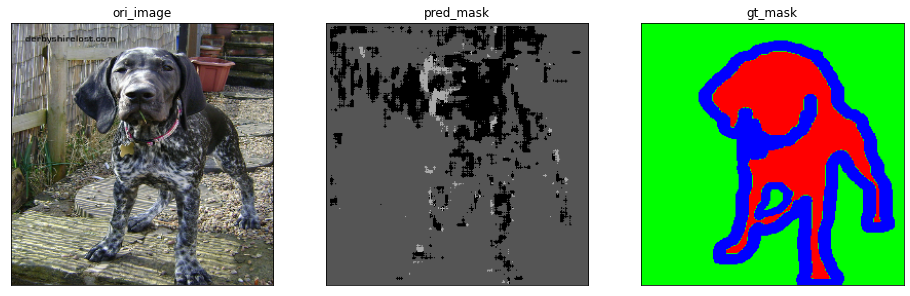

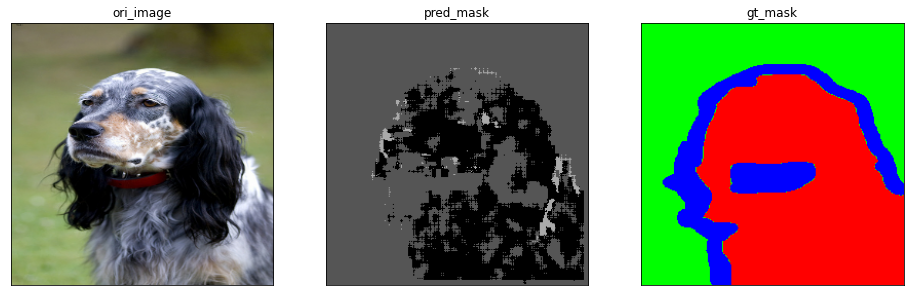

In [11]:
for test_image, test_gt_mask in test_ds.shuffle(1024).map(map_data).take(5):
    pred = model.predict(tf.expand_dims(test_image, axis=0))[0]
    pred = np.argmax(pred, axis=-1)
    pred = np.expand_dims(pred, axis=-1)
    pred = (pred * (255 / 3)).astype(np.uint8)
    pred = np.concatenate([pred, pred, pred], axis=2)
    
    utils.visualize(
        ori_image=tf.cast(test_image * 255, tf.uint8), pred_mask=pred, gt_mask=test_gt_mask
    )

# Evaluation
- Using IoU for each class
- mIoU for each class

In [12]:
def iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    
    return np.sum(intersection) / np.sum(union)

In [13]:
total_scores = {
    'class_0': [],
    'class_1': [],
    'class_2': []
}

for test_image, test_gt_mask in test_ds.map(map_data):
    test_pred_results = model.predict(tf.expand_dims(test_image, axis=0))[0]
    test_pred_results = np.argmax(test_pred_results, axis=-1)
    
    for i in range(3):
        class_pred_mask = (test_pred_results.ravel() == i).reshape(256, 256).astype(np.uint8)
        iou_score = iou(test_gt_mask[:,:, i], class_pred_mask) 
        total_scores['class_' + str(i)].append(iou_score)

In [14]:
for score in total_scores:
    print('For {}, mIoU: {} %'.format(score, round(np.mean(total_scores[score]) * 100, 2)))

For class_0, mIoU: 31.87 %
For class_1, mIoU: 60.74 %
For class_2, mIoU: 6.58 %


# Save Model

In [15]:
model_path = 'model/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
model.save(model_path + 'miniunet.h5')